### Background:

This notebook presents an analysis conducted on molecular data to offer recommendations for selecting starting molecules for an undisclosed experiment. The analysis focuses on two primary datasets: 

- **`molecules_rdkit.csv`**: Contains molecules along with their characteristic features.
- **`molecules_results.csv`**: Includes molecules with associated "damage" and "performance" metrics, indicating the performance of each molecule.

The molecules listed in these datasets are being considered for the experiment, and based on their available features, we aim to address several practical questions outlined below.

#### Questions:

1. **Candidate Selection**: 
   - The objective is to select the first 20 molecules for the experiment, ensuring a broad and efficient sampling of the latent feature space. Recommendations for the initial 20 molecules are based solely on the data provided in `molecules_rdkit.csv`.
   
2. **Predictive Model Assessment**:
   - Considering the expense of the experiment, it's crucial to assess whether the first 20 iterations are adequate for building predictive models for the outcomes. We utilize the results obtained for the selected molecules from `molecules_results.csv` to train models for estimating both "performance" and "damage," addressing this question.

3. **Optimized Sampling**:
   - Irrespective of the findings from question 2, the aim is to leverage the first 20 trials to target samples that maximize "performance" and minimize "damage" (both objectives are equally important). Models trained in question 2 are employed to evaluate the entire set of molecules, utilizing a ranking strategy to select the next 20 molecules for the experiment.
   <br/>

### Imports

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

# Define global variables
N_CLUSTERS = 20
RANDOM_STATE = 42
CORRELATION_THRESHOLD = 20

### Set paths and read in data tables

In [78]:
# Raw data
df = pd.read_csv('../molecules_rdkit.csv')
df_results= pd.read_csv('../molecules_results.csv')

print("Total number of molecules in dataset:", df.shape[0])
print("Total number of features in molecules_rdkit.csv: ", df.shape[1]-1)

Total number of molecules in dataset: 4294
Total number of features in molecules_rdkit.csv:  1433


### Data Preprocessing

Data Normalization

In [79]:
scaler = StandardScaler()

# Apply z-score normalization to molecules_rdkit.csv
df_numeric = df.drop('name', axis=1)
df_normalized = scaler.fit_transform(df_numeric)
df_normalized = pd.DataFrame(df_normalized, columns=df_numeric.columns)

# Apply z-score normalization to molecules_results.csv
df_results_numeric = df_results.drop('name', axis=1)
df_results_normalized = scaler.fit_transform(df_results_numeric)
df_results_normalized = pd.DataFrame(df_results_normalized, columns=df_results_numeric.columns)

df = pd.concat([df_normalized, df['name']], axis=1)
df_results = pd.concat([df_results_normalized, df_results['name']], axis=1)

Feature Selection 1: 


Dropping columns where missing values percentage is beyond threshold

There are total 690 columns with missing values.


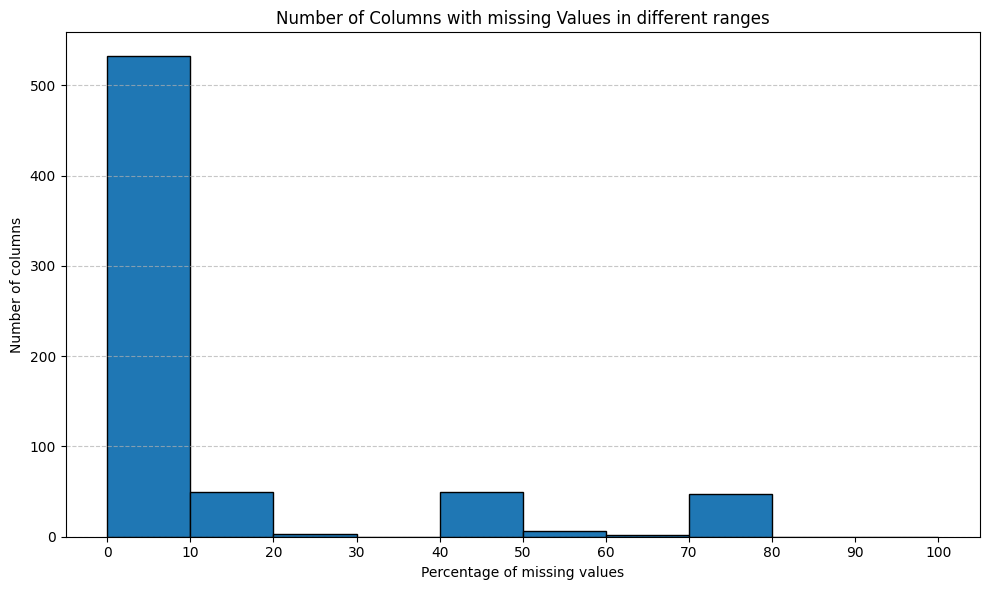

In [80]:
columns_with_missing_values = df.columns[df.isnull().any()]
total_rows = len(df)

# Count the number of missing values in each column
missing_values_counts = df[columns_with_missing_values].isnull().sum()
# Calculate the percentage of missing values for each column
missing_percentage = (missing_values_counts / total_rows) * 100

bins = range(0, 101, 10) 

print("There are total "+ str(len(columns_with_missing_values))+ " columns with missing values.")
plt.figure(figsize=(10, 6))
plt.hist(missing_percentage, bins=bins, edgecolor='black')
plt.title('Number of Columns with missing Values in different ranges')
plt.xlabel('Percentage of missing values')
plt.ylabel('Number of columns')
plt.xticks(bins)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Based on the plot above, we choose a threshold of 20% to remove columns where the missing value percentage is greater than 20%. The missing values in the remaining columns are then replaced by the mean of the corresponding column.

In [82]:
columns_below_threshold = missing_percentage[missing_percentage <= CORRELATION_THRESHOLD].index

# Identify columns without missing values
columns_without_missing_values = df.columns[~df.isnull().any()]

df_subset = df[columns_without_missing_values.to_list() + columns_below_threshold.to_list()]

# Fill missing values with mean of corresponding column
mean_values = df_subset[columns_below_threshold].mean()
df_subset.loc[:, columns_below_threshold] = df_subset.loc[:, columns_below_threshold].fillna(mean_values)

print("Number of features in the dataset after feature selection 1: ", df_subset.shape[1]-1)

Number of features in the dataset after feature selection 1:  1325


In [36]:
columns_below_threshold

Index(['AATS0s', 'AATS0se', 'AATS1Z', 'AATS1are', 'AATS1d', 'AATS1dv',
       'AATS1i', 'AATS1m', 'AATS1p', 'AATS1pe',
       ...
       'VR3_Dzi', 'VR3_Dzm', 'VR3_Dzp', 'VR3_Dzpe', 'VR3_Dzse', 'VR3_Dzv',
       'Vabc', 'Xp-0d', 'Xp-0dv', 'mZagreb1'],
      dtype='object', length=582)

Feature Selection 2: 

Discarding columns having same values throughout

In [83]:
# Identify constant columns
constant_columns = df_subset.columns[df_subset.nunique() == 1]
print("There are total "+ str(len(constant_columns))+ " columns that have same values.")
df_subset = df_subset.drop(columns =  constant_columns.to_list())

There are total 122 columns that have same values.


In [84]:
print("Number of features in the dataset after feature selection 2: ", df_subset.shape[1]-1)

Number of features in the dataset after feature selection 2:  1203


Feature Selection 3:

We use correlation matrix to identify highly correlated features and choose one among those features in our analysis and drop the rest. We use threshold magnitude of 0.7 and do pairwise correlation.

In [85]:
eliminated_features = []
selected_features = pd.DataFrame(columns=['Feature'])
df_numeric = df_subset.drop('name', axis=1)

for feature in df_numeric.columns:

    if feature in eliminated_features:
        continue
    else:
      # Calculate correlation magnitude with respect to the feature in loop
      correlations = df_numeric.corrwith(df_numeric[feature]).abs()
      # Extract features having correlation magnitude >0.7 
      correlated_features = correlations[correlations > 0.7].index.tolist()
      correlated_features.remove(feature)
      eliminated_features.extend(correlated_features)

      selected_features = pd.concat([selected_features, pd.DataFrame([{'Feature': feature}])], ignore_index=True)

print("Total number of selected features: ", len(selected_features))
print("\nSelected features:")
print(selected_features)

df_subset = df_subset[['name'] + selected_features['Feature'].tolist()]


Total number of selected features:  321

Selected features:
       Feature
0       AATS0Z
1     AATS0are
2       AATS0d
3       AATS0i
4       AATS0p
..         ...
316       RPCG
317   RotRatio
318    SM1_DzZ
319  SpMAD_Dzp
320      VR1_A

[321 rows x 1 columns]


### Q1

We perform k-means clustering with k=20 to identify 20 clusters and choose one molecule from each cluster for experiment.

In [86]:
df_numeric = df_subset.drop('name', axis=1)

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)  
kmeans.fit(df_numeric)

cluster_labels = kmeans.labels_
df_subset.loc[:, 'Cluster'] = cluster_labels

In [87]:
# Dataframe to store first 20 molecules to be recommended
sample_points = pd.DataFrame()

for cluster_label in np.unique(df_subset['Cluster']):

    cluster_data = df_subset[df_subset['Cluster'] == cluster_label]

    # Randomly select one data point/molecule from the current cluster
    random_index = np.random.choice(cluster_data.index)
    random_data_point = cluster_data.loc[random_index]
    sample_points = pd.concat([sample_points, pd.DataFrame([random_data_point])], ignore_index=True)


df_subset = df_subset.drop('Cluster', axis=1)

pd.set_option('display.max_colwidth', None)
print("First 20 molecules: \n")
print(sample_points['name'].to_string(index=False))

First 20 molecules: 

                                                              9_nitroanthracene
                                                      n_methylpyrimidin_2_amine
                                                         1_ethylpiperazin_2_one
                                                     2_3_4_trimethylpentan_3_ol
                                                2_bromo_2_nitropropane_1_3_diol
                                                                    cyclohexene
                                                                          litdi
                                                         sorbitan_diisostearate
                                                        n_methyl_4_nitroaniline
                                                                      lead_atom
                                             1_4_dihydroxyanthracene_9_10_dione
                                                           4_methyloxetan_2_one
                  

### Q2

In [88]:
selected_molecules_indices = sample_points.index

# Extract results for the selected molecules from molecules_results.csv
selected_molecules_results = df_results.loc[selected_molecules_indices]

merged_df = pd.merge(df_results, sample_points, on='name', how='inner')
merged_df = merged_df.drop('Cluster', axis=1)
merged_df

,performance,damage,name,AATS0Z,AATS0are,AATS0d,AATS0i,AATS0p,AATS0v,AATSC0Z,...,MATS3dv,MATS4v,MDEC-22,PetitjeanIndex,RNCG,RPCG,RotRatio,SM1_DzZ,SpMAD_Dzp,VR1_A
0,0.616508,0.715872,1_4_dihydroxyanthracene_9_10_dione,0.004242,0.488064,2.083188,-1.109460,-0.023141,0.802087,-0.275204,...,1.468886,0.048724,3.825640e-02,1.806591e-01,-0.910877,-0.754830,-0.812738,6.282112e-01,2.370102e-01,-2.882638e-02
1,-0.290397,-0.198442,1_ethylpiperazin_2_one,-0.093008,-0.275362,-0.386369,0.445856,-0.064299,-0.495204,-0.191128,...,0.231107,-0.884556,-3.494861e-01,-9.285458e-02,-0.408646,0.068551,-0.281317,-1.592692e-01,1.484476e-01,-2.935304e-02
2,-0.164343,-0.176836,2_3_4_trimethylpentan_3_ol,-0.136173,-0.815536,-0.869257,0.162063,-0.068120,-0.732162,-0.350895,...,-1.126481,-0.722053,-1.597623e-16,8.644433e-01,0.917055,0.617553,0.382959,-6.438725e-01,-2.204638e-01,-2.939175e-02
3,2.520726,1.341917,2_5_8_15_18_21_hexaoxatricyclo_20_4_0_09_14_hexacosa_1_26_9_11_13_22_24_hexaene,-0.057639,0.006340,0.325812,-0.380853,-0.048360,0.005123,-0.146523,...,0.896163,-0.308348,3.378941e+00,-9.765142e-01,-1.640513,-1.772173,-0.812738,1.476267e+00,3.963291e+00,-2.817435e-02
4,0.301755,0.276415,2_bromo_2_nitropropane_1_3_diol,0.714189,1.397737,0.286558,0.565936,-0.032998,0.105874,7.298598,...,0.778630,-0.334941,-7.538598e-01,8.644433e-01,-0.759266,0.081366,0.980808,2.275863e+00,5.672398e-01,-2.938228e-02
5,-0.260829,-0.207791,2_n_methylbenzene_1_2_diamine,-0.089674,-0.480866,-0.157633,0.031299,-0.049677,-0.156474,-0.264120,...,-0.153727,-1.016004,-1.309015e-01,-9.285458e-02,-0.054676,-0.709699,-0.281317,-5.832971e-01,-3.369812e-01,-2.935304e-02
6,-0.301677,-0.209223,4_methyloxetan_2_one,-0.052260,0.278290,0.139355,-0.026993,-0.059551,-0.225180,-0.063655,...,-0.750998,1.155901,-1.597623e-16,8.644433e-01,1.359320,1.748156,-0.812738,-2.198446e-01,-5.538615e-01,-2.946039e-02
7,0.425288,0.193237,9_nitroanthracene,-0.022360,0.062904,1.686873,-1.021321,-0.022063,0.721985,-0.295330,...,1.407430,-0.017586,1.251736e+00,1.806591e-01,-1.072227,0.372721,-0.561012,2.245704e-02,2.217895e-01,-2.886118e-02
8,-0.270045,-0.070224,carbon_dioxide,0.227067,4.279786,-1.087335,-0.002783,-0.051993,0.993148,-1.018947,...,0.000000,0.000000,-1.597623e-16,8.644433e-01,0.556325,7.387728,-0.812738,-2.198446e-01,-1.255021e+00,-2.954709e-02
9,-0.300750,-0.204279,cyclohexene,-0.132437,-0.992090,-0.903331,-0.254813,-0.054635,-0.416281,-0.392802,...,0.243880,0.390821,7.966957e-01,-3.922046e+00,-1.034711,-0.691482,-0.812738,-1.067900e+00,-9.619501e-01,-2.945839e-02


Since we have total 321 features after feature selection and 20 examples, there is a higher chance that any model would overfit on data as number of features is very high compared to training examples. We use random forest as a starting model as they generally perform well on higher dimensional data and are less prone to overfitting due to ensemble nature of the model.

Ideally, we would perform model selection- train multiple models and pick one that performs better compared to other models. Additional hyperparameter tuning/regularization may be required depending on the models used. 

In [89]:
X= merged_df.iloc[:, 3:]; y= merged_df[['performance','damage']]

loo = LeaveOneOut()

train_scores = []
validation_scores = []

# Perform leave-one-out cross-validation
for train_index, val_index in loo.split(X):

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    rf_regressor = RandomForestRegressor()
    rf_regressor.fit(X_train, y_train)

    # Predict on the train and validation sets
    y_train_pred = rf_regressor.predict(X_train)
    y_val_pred = rf_regressor.predict(X_val)

    # Mean squared error for train and validation set
    train_mse = mean_squared_error(y_train, y_train_pred)
    validation_mse = mean_squared_error(y_val, y_val_pred)

    train_scores.append(train_mse)
    validation_scores.append(validation_mse)

mean_train_mse = sum(train_scores) / len(train_scores)
mean_validation_mse = sum(validation_scores) / len(validation_scores)
print("Mean Train MSE:", mean_train_mse)
print("Mean Validation MSE:", mean_validation_mse)

final_model = RandomForestRegressor()
final_model.fit(X,y)


Mean Train MSE: 0.6599872963871211
Mean Validation MSE: 5.169555650237333


RandomForestRegressor()

**First 20 iterations are not enough**!

It is clearly overfitting as expected since the model performs well on train set and performs poorly on test/validation test since the validation/test error is very high compared to train error. It is also quite evident why it would overfit since the model is trained on only 20 molecules and number of features (321) is very high compared to the train set size. 

To solve this problem, as a first step, the train set size must be increased and number of features in training must be decreased with the help of domain knowledge and additional feature selection or dimensionality reduction techniques.

### Q3

In [90]:
# Extract unselected molecules from the dataframe
unselected_molecules = df_subset.drop(selected_molecules_indices)
unselected_molecules = unselected_molecules.reset_index(drop=True)

# Predict performance and damage on unselected molecules
y_predictions = final_model.predict(unselected_molecules[selected_features['Feature']])

To find next 20 molecules for trial we use the following objective function:

objective function = (normalised) performance - (normalised) damage.

Higher the value of objective function, higher will be the performance and lower will be the damage. After sorting the molecules by their objective function in descending order, we recommend top 20 molecules for trial based on this objective function.

In [91]:
unselected_molecules['performance_pred'] = y_predictions[:, 0]
unselected_molecules['damage_pred'] = y_predictions[:, 1]
unselected_molecules['objective'] = unselected_molecules['performance_pred']- unselected_molecules['damage_pred']

# Sort the DataFrame based on the 'objective' column in descending order
sorted_df = unselected_molecules.sort_values(by='objective', ascending=False)

top_20_rows = sorted_df.head(20)
print("The next 20 molecules for experiment are: \n")
print(top_20_rows['name'].to_string(index=False))

The next 20 molecules for experiment are: 

                                                                          litdi
                                                                         litfsi
                                                 3_trifluoromethyl_benzoic_acid
                                              1_nitro_3_trifluoromethyl_benzene
                                                      4_trifluoromethyl_aniline
2_5_8_15_18_21_hexaoxatricyclo_20_4_0_09_14_hexacosa_1_26_9_11_13_22_24_hexaene
                                             1_chloro_4_trifluoromethyl_benzene
                                                                            hfe
                   1_1_1_trifluoro_n_trifluoromethylsulfonyl_methanesulfonamide
                                       ethanolaminebis_methylenephosphonic_acid
                                             2_phosphonomethylamino_acetic_acid
                                                                           b